In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import *
nltk.download('stopwords')
nltk.download('wordnet')

import re
import statistics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
training_dataset = pd.read_csv('../../PrimaryDataset/firefox_preproccessed_whole_dataset.csv')

print('Dimensions of Dataset: ', training_dataset.shape)

Dimensions of Dataset:  (38290, 11)


In [3]:
#Replacing Blank Values with 'NaN' Values
training_dataset.replace("", np.nan, inplace = True)

#Droping Data which has 'Nan' value for 'Description' Column
training_dataset.dropna(subset = ['Description'], inplace = True)

#Checking of any 'NaN' values are present or not.
cond = (training_dataset['Description'] == np.nan)
print('NaN Values after Replacing: ',len(cond))

#Filtering data based on 'Duplicate_Bug_Ids' Column to get Duplicate Bugs
duplicate_test = training_dataset[training_dataset['Duplicate_Bug_Ids'] > 0]
print('Dimensions of Data with Duplicate Bug Ids: ', duplicate_test.shape)

NaN Values after Replacing:  38290
Dimensions of Data with Duplicate Bug Ids:  (7859, 11)


In [4]:
#To Tokenize Data
ted = duplicate_test['Description']

tfidf = TfidfVectorizer()
stemmer = PorterStemmer()

def tokenizer(arg):
    tokens = re.split(r'(\W+)', arg.lower())
    tokens = [
        token for token in tokens
        if re.match('\\w+', token) and not re.match('\\d+', token)
    ]
    
    return list(map(stemmer.stem, tokens))

tfidf.tokenizer = tokenizer
tfidf_matrix_desc = tfidf.fit_transform(ted)

print('Dimensions of Data after Tokenization: ', tfidf_matrix_desc.shape)

Dimensions of Data after Tokenization:  (7859, 14864)


In [5]:
#To calculate Cosine Similarity
tfidf_sim = TfidfVectorizer()

tfidf_matrix = tfidf_sim.fit_transform(ted)

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print('Cosine Similarity Matrix:')
print(cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.04122147 0.04019784 ... 0.02639855 0.042071   0.01534793]
 [0.04122147 1.         0.07110638 ... 0.06228067 0.03302893 0.01394963]
 [0.04019784 0.07110638 1.         ... 0.05066284 0.0219455  0.02641063]
 ...
 [0.02639855 0.06228067 0.05066284 ... 1.         0.11492979 0.00451332]
 [0.042071   0.03302893 0.0219455  ... 0.11492979 1.         0.00434397]
 [0.01534793 0.01394963 0.02641063 ... 0.00451332 0.00434397 1.        ]]
Cosine Similarity Matrix Dimensions:  (7859, 7859)


In [6]:
#To get Average Cosine Similarity Score
average = np.average(cosine_sim, axis=1)
average_df = pd.DataFrame(average, columns = ['Avg_Sim_Score'])

#To sort Data
average_for_sorting = average_df
sorted_average = average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(average))

#To get Median Of Distribution
median = statistics.median(average)
print('Median of Distribution: ', median)

Skewness of Distribution:  -0.049826805982141224
Median of Distribution:  0.060176621036006114


In [7]:
#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Score', value = average_df.values)

similar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= median]
dissimilar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] < median]

print('Simlar Scores Dataset Dimensions: ', similar_score.shape)
print('Disimlar Scores Dataset Dimensions: ', dissimilar_score.shape)

#To get Average Similarity Scores 
scores = sorted_average['Avg_Sim_Score'].values.tolist()

Simlar Scores Dataset Dimensions:  (3930, 12)
Disimlar Scores Dataset Dimensions:  (3929, 12)


In [8]:
#To get data for BoxPlot

def get_box_plot_data(scores, title):
    scores_df = pd.DataFrame(scores)
    
    labels = ['Scores']
    plt.boxplot([scores], labels = labels)
    plt.ylabel('Cosine Similarity')
    plt.title(title)
    plt.show()
    
    scores_desc = {}
    scores_desc['lower_quartile'] = scores_df.describe().loc['25%']
    scores_desc['median'] = scores_df.describe().loc['50%']
    scores_desc['upper_quartile'] = scores_df.describe().loc['75%']
        
    return pd.DataFrame(scores_desc)

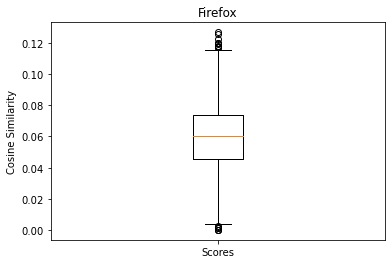

,lower_quartile,median,upper_quartile
0,0.045692,0.060177,0.074049


In [9]:
#To plot Box-Plot
result = get_box_plot_data(scores, 'Firefox')

#To get Description of Scores
result.head()

In [10]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs: ', similar_final_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs: ', dissimilar_final_score.shape)

Dimensions of Filtered Data with Similar Duplicate Bugs:  (1965, 12)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs:  (1965, 12)


# Unigram

In [11]:
#Unigram
unigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True, min_df=2)

unigram = unigram_vector.fit_transform(ted)

unigram_cosine_sim = cosine_similarity(unigram, unigram)

print('Cosine Similarity Matrix:')
print(unigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', unigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.04245795 0.04045055 ... 0.02721041 0.042071   0.0154029 ]
 [0.04245795 1.         0.07369971 ... 0.06612169 0.03401967 0.01441953]
 [0.04045055 0.07369971 1.         ... 0.05254922 0.02208346 0.02667185]
 ...
 [0.02721041 0.06612169 0.05254922 ... 1.         0.11846437 0.00466879]
 [0.042071   0.03401967 0.02208346 ... 0.11846437 1.         0.00435953]
 [0.0154029  0.01441953 0.02667185 ... 0.00466879 0.00435953 1.        ]]
Cosine Similarity Matrix Dimensions:  (7859, 7859)


In [12]:
#To get Average Unigram Cosine Similarity Score
unigram_average = np.average(unigram_cosine_sim, axis=1)
unigram_average_df = pd.DataFrame(unigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
unigram_average_for_sorting = pd.DataFrame(unigram_average_df)
sorted_unigram_average = unigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(unigram_average))

#To get Median Of Distribution
unigram_median = statistics.median(unigram_average)
print('Median of Distribution: ', unigram_median)

#To get Unigram Scores
unigram_scores = sorted_unigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  -0.0710382579794963
Median of Distribution:  0.06332519385251839


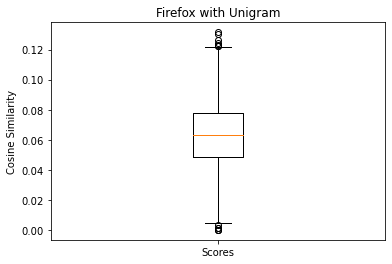

,lower_quartile,median,upper_quartile
0,0.048253,0.063325,0.07755


In [13]:
#To plot Box-Plot
result = get_box_plot_data(unigram_scores, 'Firefox with Unigram')

#To get Description of Unigram Scores
result.head()

In [14]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram: ', similar_unigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram: ', dissimilar_unigram_score.shape)

#Download to csv
similar_unigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_similar_unigram_final.csv",index=False)
dissimilar_unigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_dissimilar_unigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram:  (1556, 12)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram:  (2309, 12)


# Bigram

In [15]:
#Bigram
bigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,2), lowercase=True, min_df=2)

bigram = bigram_vector.fit_transform(ted)

bigram_cosine_sim = cosine_similarity(bigram, bigram)

print('Cosine Similarity Matrix:')
print(bigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', bigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02521412 0.02161435 ... 0.01077285 0.01909951 0.00715465]
 [0.02521412 1.         0.03488997 ... 0.02475384 0.01550532 0.00676029]
 [0.02161435 0.03488997 1.         ... 0.02144234 0.01105035 0.0163111 ]
 ...
 [0.01077285 0.02475384 0.02144234 ... 1.         0.07914972 0.00203209]
 [0.01909951 0.01550532 0.01105035 ... 0.07914972 1.         0.00229606]
 [0.00715465 0.00676029 0.0163111  ... 0.00203209 0.00229606 1.        ]]
Cosine Similarity Matrix Dimensions:  (7859, 7859)


In [16]:
#To get Average Bigram Cosine Similarity Score
bigram_average = np.average(bigram_cosine_sim, axis=1)
bigram_average_df = pd.DataFrame(bigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
bigram_average_for_sorting = bigram_average_df
sorted_bigram_average = bigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(bigram_average))

#To get Median Of Distribution
bigram_median = statistics.median(bigram_average)
print('Median of Distribution: ', bigram_median)

#To get Bigram Scores
bigram_scores = sorted_bigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  -0.17110761734715704
Median of Distribution:  0.0297766713772623


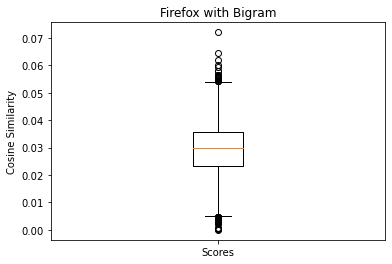

,lower_quartile,median,upper_quartile
0,0.02326,0.029777,0.035516


In [17]:
#To plot Box-Plot
result = get_box_plot_data(bigram_scores, 'Firefox with Bigram')

#To get Description of Unigram Scores
result.head()

In [18]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Bigram', value = bigram_average_df.values)

#To Filter data for Similar Bugs
similar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram: ', similar_bigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram: ', dissimilar_bigram_score.shape)

#Download to csv
similar_bigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_similar_bigram_final.csv",index=False)
dissimilar_bigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_dissimilar_bigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram:  (1965, 13)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram:  (1965, 13)


# Trigram

In [19]:
#Trigram
trigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,3), lowercase=True, min_df=2)

trigram = trigram_vector.fit_transform(ted)

trigram_cosine_sim = cosine_similarity(trigram, trigram)

print('Cosine Similarity Matrix:')
print(trigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', trigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02103657 0.01849083 ... 0.00715837 0.01249891 0.00496291]
 [0.02103657 1.         0.0323174  ... 0.01913736 0.01213475 0.00562237]
 [0.01849083 0.0323174  1.         ... 0.0169888  0.00889362 0.01390382]
 ...
 [0.00715837 0.01913736 0.0169888  ... 1.         0.06194188 0.00155484]
 [0.01249891 0.01213475 0.00889362 ... 0.06194188 1.         0.00177324]
 [0.00496291 0.00562237 0.01390382 ... 0.00155484 0.00177324 1.        ]]
Cosine Similarity Matrix Dimensions:  (7859, 7859)


In [20]:
#To get Average Of Distribution
trigram_average = np.average(trigram_cosine_sim, axis=1)
trigram_average_df = pd.DataFrame(trigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
trigram_average_for_sorting = trigram_average_df
sorted_trigram_average = trigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(trigram_average))

#To get Median Of Distribution
trigram_median = statistics.median(trigram_average)
print('Median of Distribution: ', trigram_median)

#To get Trigram Scores
trigram_scores = sorted_trigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  -0.19234811804156507
Median of Distribution:  0.023242112154572205


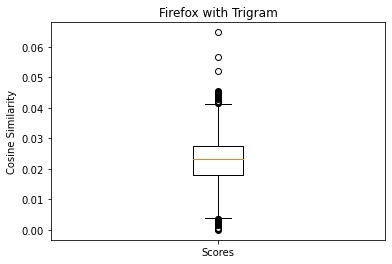

,lower_quartile,median,upper_quartile
0,0.017871,0.023242,0.027378


In [21]:
#To plot Box-Plot
result = get_box_plot_data(trigram_scores, 'Firefox with Trigram')

#To get Description of Unigram Scores
result.head()

In [22]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Trigram', value = trigram_average_df.values)

#To Filter data for Similar Bugs
similar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram: ', similar_trigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram: ', dissimilar_trigram_score.shape)

#Download to csv
similar_trigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_similar_trigram_final.csv",index=False)
dissimilar_trigram_score.to_csv("../../PreProcessedData/Firefox/Firefox_textually_dissimilar_trigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram:  (1965, 14)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram:  (1965, 14)


# Comparing Unigram and Bigram

In [23]:
#Comparing Similar Unigram and Bigram
print('Is Similar Unigram and Bigram Data Same?: ', similar_bigram_score['Bug ID'].equals(similar_unigram_score['Bug ID']))

#To convert Data in List
unigram_bug_list = list(similar_unigram_score['Bug ID'])
bigram_bug_list = list(similar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Similar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id = []
for i,v in enumerate(bigram_bug_list):
    if (v in unigram_bug_list):
        count_id +=1
        dup_id_in_bug_id.append(v)
        
print('Duplicate Bug IDs in Similar Unigram and Bigram Data: ', len(dup_id_in_bug_id))

#To get Similar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_sim = similar_bigram_score[similar_bigram_score['Bug ID'].isin(dup_id_in_bug_id)]

print('Dimensions of new Data: ', new_sim.shape)

Is Similar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Unigram and Bigram Data:  1385
Dimensions of new Data:  (1385, 13)


In [24]:
#Comparing Dis-similar Unigram and Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', dissimilar_bigram_score['Bug ID'].equals(dissimilar_unigram_score['Bug ID']))

#To convert Data in List
unigram_dis_bug_list = list(dissimilar_unigram_score['Bug ID'])
bigram_dis_bug_list = list(dissimilar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id_dis = []
for i,v in enumerate(bigram_dis_bug_list):
    if (v in unigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis.append(v)
        
print('Duplicate Bug IDs in Dissimilar Unigram and Bigram Data: ', len(dup_id_in_bug_id_dis))

#To get Dissimilar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_dissim = dissimilar_bigram_score[dissimilar_bigram_score['Bug ID'].isin(dup_id_in_bug_id_dis)]

print('Dimensions of new Data: ', new_dissim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Unigram and Bigram Data:  1710
Dimensions of new Data:  (1710, 13)


# Comparing Trigram and Unigram-Bigram

In [25]:
#Comparing Similar Trigram and Unigram-Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', similar_trigram_score['Bug ID'].equals(new_sim['Bug ID']))

#To convert Data in List
trigram_bug_list = list(similar_trigram_score['Bug ID'])
unigram_bigram_bug_list = list(new_sim['Bug ID'])

#To get Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_tri = []
for i,v in enumerate(trigram_bug_list):
    if (v in unigram_bigram_bug_list):
        count_id +=1
        dup_id_in_bug_id_tri.append(v)
        
print('Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_tri))

#To get Similar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_sim = similar_trigram_score[similar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_tri)]

print('Dimensions of new Data: ', final_new_sim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data:  1239
Dimensions of new Data:  (1239, 14)


In [26]:
#Comparing Dissimilar Trigram and Unigram-Bigram
print('Is Disimilar Trigram and Unigram-Bigram Data Same?: ', dissimilar_trigram_score['Bug ID'].equals(new_dissim['Bug ID']))

#To convert Data in List
trigram_dis_bug_list = list(dissimilar_trigram_score['Bug ID'])
unigram_bigram_dis_bug_list = list(new_dissim['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_dis_tri = []
for i,v in enumerate(trigram_dis_bug_list):
    if (v in unigram_bigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis_tri.append(v)
        
print('Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_dis_tri))

#To get Dissimilar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_dissim = dissimilar_trigram_score [dissimilar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_dis_tri)]

print('Dimensions of new Data: ', final_new_dissim.shape)

#Download to csv
final_new_sim.to_csv("../../PreProcessedData/Firefox/Firefox_final_sim.csv",index=False)
final_new_dissim.to_csv("../../PreProcessedData/Firefox/Firefox_final_dis.csv",index=False)

Is Disimilar Trigram and Unigram-Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data:  1589
Dimensions of new Data:  (1589, 14)


# Textually Similar

In [27]:
#To Drop Duplicates
df_sim = final_new_sim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_sim.shape)

# Duplicate Pair ( b- & b+)
sim = df_sim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
sim.reset_index(drop=True, inplace=True)
na = sim.to_numpy()

def createData(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_sim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]].copy()
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
sim['Summary1'] = createData('Bug ID', 'Summary', 0)
sim['Description1'] = createData('Bug ID', 'Description', 0)
sim['Summary2'] = createData('Bug ID', 'Summary', 1)
sim['Description2'] = createData('Bug ID', 'Description', 1)
sim['is_similar'] = 1

#To show Data
sim.head()

Dimensions of Data After Dropping Duplicates:  (1239, 14)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,1369688,1331736.0,0.028173,['One-off search takes the initial value rathe...,['created attachment keyselectedsearch mo...,['Alt+down in location bar searches for origin...,['i noticed this while working on bug and i...,1
1,1332106,1332118.0,0.041752,['[Deleted][Windows 10] Possible Cortana Searc...,['user agent mozilla gecko firefox ...,[],[],1
2,1328104,1323525.0,0.030858,['Add Search Engine Button Does Not Work'],['user agent mozilla gecko firefox ...,[],[],1
3,1333599,1481994.0,0.038145,['URL Spoofing by using onbeforeunload and ope...,['i have noticed that the onbeforeunload dialo...,[],[],1
4,1351282,1401401.0,0.037071,['Cannot delete or edit invalid bookmark'],['created attachment bug dialog png user ag...,['Bookmarks with an invalid url cannot be remo...,['created attachment screenshot of bookmark ...,1


In [28]:
#To Create a Copy
df_sim_fin = sim.copy()

#To Replace '[]' with '0' 
df_sim_fin['Summary2'] = df_sim_fin['Summary2'].replace(['[]'],'0')
df_sim_fin['Description2'] = df_sim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_sim_fin.shape)

Dimensions of Data after Cleaning:  (536, 8)


# Textually Dissimilar

In [29]:
#To Drop Duplicate
df_dissim = final_new_dissim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_dissim.shape)

# Duplicate Pair ( b- & b+)
dissim = df_dissim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
dissim.reset_index(drop=True, inplace=True)
na = dissim.to_numpy()

def createDataForDissimilarity(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_dissim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]]
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
dissim['Summary1'] = createDataForDissimilarity('Bug ID', 'Summary', 0)
dissim['Description1'] = createDataForDissimilarity('Bug ID', 'Description', 0)
dissim['Summary2'] = createDataForDissimilarity('Bug ID', 'Summary', 1)
dissim['Description2'] = createDataForDissimilarity('Bug ID', 'Description', 1)
dissim['is_similar'] = 1

#To show Data
dissim.head()

Dimensions of Data After Dropping Duplicates:  (1589, 14)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,1357039,1357029.0,0.010312,['Should add the Customize Firefox tour in the...,['should add the customize firefox tour in the...,['Should add the Add-on tour in the onBoarding...,['should add the add on tour in the onboarding...,1
1,1359062,1347543.0,0.014964,['Increase contrast of the Downloads Indicator...,['nightly on windows at the moment ...,['Change Toolbar Icons from PNG to SVG'],[' this bug was initially created as a clon...,1
2,1357056,1357641.0,0.009494,['Should not display the notification bar if u...,['should not display the notification for the ...,['Should show the notification bar to notify u...,['should show the notification bar to notify u...,1
3,1357041,1357029.0,0.012423,['Should highlight the customize button in the...,['should highlight the customize button in the...,['Should add the Add-on tour in the onBoarding...,['should add the add on tour in the onboarding...,1
4,1378164,1377923.0,0.015985,"[""Noisy debug in a debug build (of Thunderbird...",[' this bug was initially created as a clon...,[],[],1


In [30]:
#To Create a Copy
df_dissim_fin= dissim.copy()

#To Replace '[]' with '0' 
df_dissim_fin['Summary2'] = df_dissim_fin['Summary2'].replace(['[]'],'0')
df_dissim_fin['Description2'] = df_dissim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_dissim_fin.shape)

Dimensions of Data after Cleaning:  (816, 8)


In [31]:
#To Download Final Processed Data
df_sim_fin.to_csv("../../PreProcessedData/Firefox/Firefox_textually_similar_pair.csv")
df_sim_fin.to_csv("../../PreProcessedData/Firefox/Firefox_textually_dissimilar_pair.csv")